# Overview
* Objective: This project focuses on creating a sophisticated algorithm for image classification, distinguishing various natural scenes from images. The goal is accurate identification, categorizing of natural scene into different labels.

* Our approach: We will be employing Convolutional Neural Networks (CNNs), a powerful class of deep learning models tailored for visual image analysis. CNNs excel in detecting patterns and features within images, making them well-suited for identifying subtle variations in images indicative of different scenes. We will build and compare multiple models and evaluate their performance using ROC curve.

* Dataset: We’ll use the dataset from the Kaggle website from Intel Image Classification challenge. This is image data of Natural Scenes around the world. This Data contains around 25k images of size 150x150 distributed under 6 categories.
{'buildings' -> 0,
'forest' -> 1,
'glacier' -> 2,
'mountain' -> 3,
'sea' -> 4,
'street' -> 5 }. The Train, Test and Prediction data is separated in each zip files. There are around 14k images in Train, 3k in Test and 7k in Prediction.

Photo by Jan Böttinger on Unsplash. Intel Image Classification challenge. Kaggle: https://www.kaggle.com/datasets/puneet6060/intel-image-classification


#Data Overview
####1. Load data from Kaggle

In [ ]:
from multiprocessing import Pool
import numpy as np
import pandas as pd
import os
import cv2
import random
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.gridspec import GridSpec
from collections import Counter
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization, RandomFlip, RandomZoom, RandomRotation, Conv2D, MaxPooling2D, AveragePooling2D, Dense, Flatten, Dropout, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from keras.utils import to_categorical

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
! pip install kaggle

In [ ]:
! mkdir -p ~/.kaggle
! cp -rf /content/drive/MyDrive/Colab\ Notebooks/kaggle.json ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json
! rm -rf /content/intel-image-classification
! mkdir -p /content/intel-image-classification

In [ ]:
! kaggle datasets download -d puneet6060/intel-image-classification

 97% 336M/346M [00:02<00:00, 144MB/s]
100% 346M/346M [00:02<00:00, 140MB/s]


In [ ]:
import zipfile
import os

# Unzip the file
with zipfile.ZipFile("/content/intel-image-classification.zip", "r") as zip_ref:
   zip_ref.extractall("/content/intel-image-classification")

# Delete the zip file
os.remove("/content/intel-image-classification.zip")

Let's define load_data method to load images, class names and their corresponding labels, and sets the image size for preprocessing. The load_image function reads and processes individual images. The load_data function uses multiprocessing to load and preprocess images from given directories, and returns the processed datasets.

In [ ]:
class_names = ['mountain', 'street', 'glacier', 'buildings', 'sea', 'forest']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}
nb_classes = len(class_names)
IMAGE_SIZE = (150, 150)

def load_image(file, dataset, folder):
    img_path = os.path.join(os.path.join(dataset, folder), file)
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, IMAGE_SIZE)
    return image

def load_data(train_images_dir, test_images_dir):
    datasets = [train_images_dir, test_images_dir]
    output = []

    for dataset in datasets:
        images_list = []
        labels = []
        print("Loading {}".format(dataset))

        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            files = os.listdir(os.path.join(dataset, folder))

            with Pool() as p:
                images = p.starmap(load_image, [(file, dataset, folder) for file in files])

            images_list.extend(images)
            labels.extend([label] * len(files))

        output.append((np.array(images_list, dtype='float32'), np.array(labels, dtype='int32')))

    return output

In [ ]:
test_images_dir = '/content/intel-image-classification/seg_test/seg_test'
train_images_dir = '/content/intel-image-classification/seg_train/seg_train'
prediction_images_dir = '/content/intel-image-classification/seg_pred/seg_pred'

(orig_train_images, orig_train_labels), (orig_test_images, orig_test_labels) = load_data(train_images_dir, test_images_dir)

Loading /content/intel-image-classification/seg_train/seg_train
Loading /content/intel-image-classification/seg_test/seg_test


In [ ]:
train_images, train_labels = shuffle(orig_train_images, orig_train_labels, random_state=35)
test_images = orig_test_images
test_labels = orig_test_labels

####2. Data Inspection

In [ ]:
n_train = train_labels.shape[0]
n_test = test_labels.shape[0]

print ("Number of training examples: {}".format(n_train))
print ("Number of testing examples: {}".format(n_test))
print ("Unique labels: {}".format(np.unique(train_labels)))
print ("Each image is of size: {}".format(IMAGE_SIZE))

Number of training examples: 14034
Number of testing examples: 3000
Unique labels: [0 1 2 3 4 5]
Each image is of size: (150, 150)


We can see that the dataset contains 14034 trining samples and 3000 test samples, each representing an image.
Labels have 6 categories.

# Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data

####1. Visualize Class Distribution:

Let's create a bar chart to visualize the distribution of the 'label' column to check for potential class imbalance.
We will use a pie chart to provide a more intuitive representation of the class proportions.

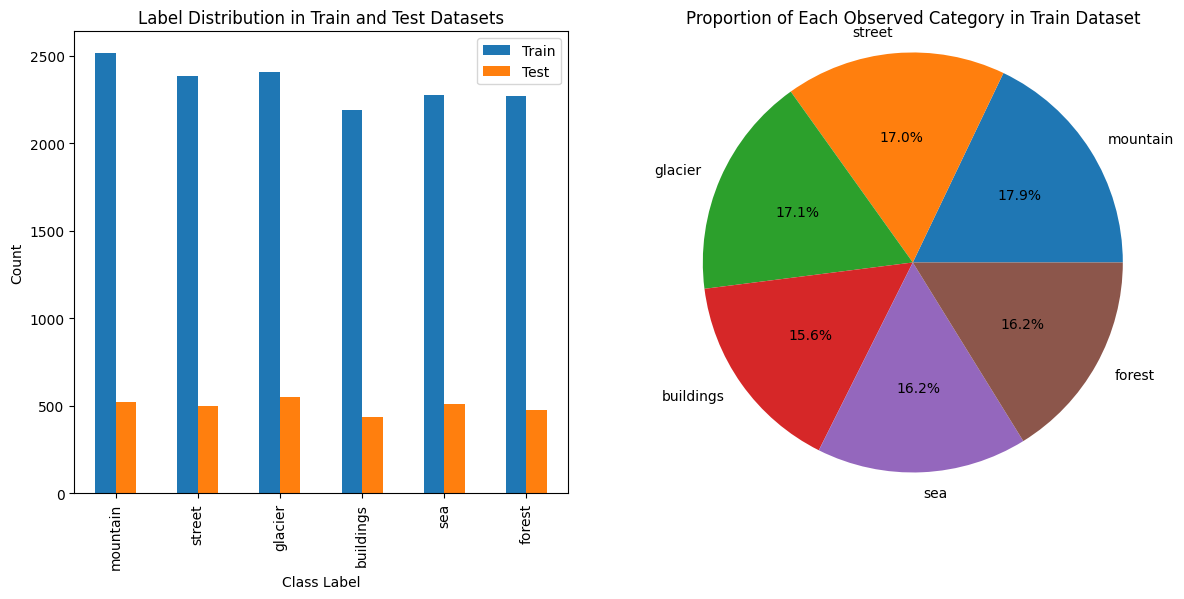

In [ ]:
_, train_counts = np.unique(train_labels, return_counts=True)
_, test_counts = np.unique(test_labels, return_counts=True)
label_counts_df = pd.DataFrame({'Train': train_counts, 'Test': test_counts}, index=class_names)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
label_counts_df.plot(kind='bar', ax=axes[0])
axes[0].set_title('Label Distribution in Train and Test Datasets')
axes[0].set_xlabel('Class Label')
axes[0].set_ylabel('Count')

# Plot pie chart
axes[1].pie(train_counts, labels=class_names, autopct='%1.1f%%')
axes[1].set_title('Proportion of Each Observed Category in Train Dataset')
axes[1].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

 We can see that our label distribution is pretty balanced with each label accounting for 16-17% images in train and test data.

####2. Visualize Image Examples:

Let's display 2 images for each class from training dataset

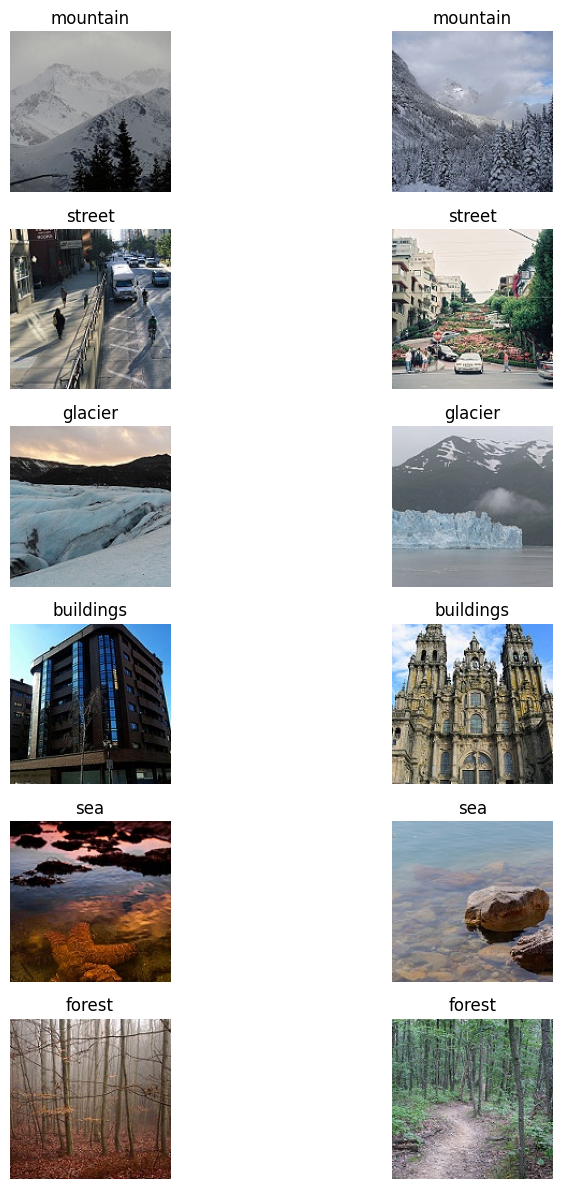

In [ ]:
def display_images(train_images, train_labels, class_names):
    fig, axes = plt.subplots(len(class_names), 2, figsize=(10, 2*len(class_names)))
    for i, class_name in enumerate(class_names):
        class_indices = [index for index, label in enumerate(train_labels) if label == class_names_label[class_name]]
        for j in range(2):  # Display two images for each class
            axes[i, j].imshow(train_images[class_indices[j]] / 255.0)  # Normalize pixel values
            axes[i, j].set_title(class_name)
            axes[i, j].axis('off')
    plt.tight_layout()
    plt.show()

# Display two images for each label
display_images(train_images, train_labels, class_names)

####3. Visualize Image Statistics

* Calculate descriptive statistics for pixel values (mean, standard deviation, minimum, maximum).
* Create histograms for each color channel to visualize pixel intensity distributions and identify potential anomalies.

Mean Pixel Values: [13.601784 13.601784 13.601784]
Standard Deviation of Pixel Values: [59.008953 59.008953 59.008953]
Minimum Pixel Values: [0. 0. 0.]
Maximum Pixel Values: [255. 255. 255.]


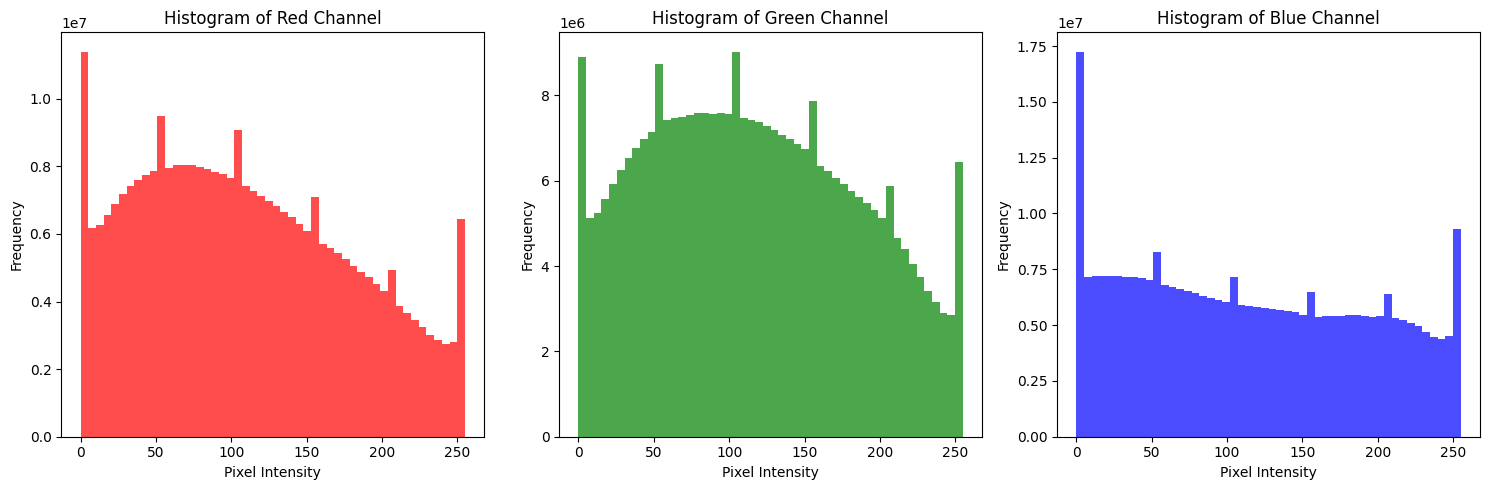

In [ ]:
# Calculate descriptive statistics for pixel values
mean_pixel_values = np.mean(train_images, axis=(0, 1, 2))
std_pixel_values = np.std(train_images, axis=(0, 1, 2))
min_pixel_values = np.min(train_images, axis=(0, 1, 2))
max_pixel_values = np.max(train_images, axis=(0, 1, 2))

# Print descriptive statistics
print("Mean Pixel Values:", mean_pixel_values)
print("Standard Deviation of Pixel Values:", std_pixel_values)
print("Minimum Pixel Values:", min_pixel_values)
print("Maximum Pixel Values:", max_pixel_values)

# Create histograms for each color channel
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i in range(3):  # Loop through RGB channels
    axes[i].hist(train_images[:, :, :, i].flatten(), bins=50, color=['red', 'green', 'blue'][i], alpha=0.7)
    axes[i].set_title(f'Histogram of {["Red", "Green", "Blue"][i]} Channel')
    axes[i].set_xlabel('Pixel Intensity')
    axes[i].set_ylabel('Frequency')
plt.tight_layout()
plt.show()

We can see that for Red and Green colors histograms show a prominent peak around a pixel intensity value between 50 - 100, while blue has peak intensity values between 0-50. The prominent peaks in Red and Green histograms suggest dominance of these colors, while lower peaks in Blue indicate lesser representation, potentially implying an imbalance in color composition or variations in luminance and contrast.

# Data Processing

####1. Scaling the images
Scaling the data is important for machine learning tasks because:

* It helps to standardize features, ensuring that all input variables contribute equally to model training and preventing models from being biased towards features with larger magnitudes.
* Scaling improves convergence speed and performance of many machine learning algorithms, especially those sensitive to feature scales like gradient * descent-based methods.
* It can enhance interpretability and facilitate better understanding of the relationships between features and the target variable by putting them on the same scale.

####2. Train and Validation Data Generator:

We will use the ImageDataGenerator class from Keras to create train and validation data (in 80:20 split) generators for loading and preprocessing images. We will be performing following tasks:
* Normalization: Normalize the image pixel values from the original range of 0-255 to a scaled range of 0-1. This normalization aids in mitigating pixel value skewness, promoting faster convergence during neural network training.

* Batch Size Selection: Choose a batch size of 256 to strike a balance between computational efficiency and model performance. This selection aims to prevent potential hindrance to generalization that might occur with excessively large batches.



In [ ]:
# Split train_images and train_labels into training and validation sets
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.2, random_state=7)

# One-hot encode the labels
train_labels = to_categorical(train_labels)
val_labels = to_categorical(val_labels)

# Initialize ImageDataGenerator with rescaling
data_gen = ImageDataGenerator(rescale=1/255)

# Create train_generator
train_generator = data_gen.flow(
    x=train_images,
    y=train_labels,
    batch_size=128,
    seed=7,
    shuffle=True
)

# Create validation_generator
validation_generator = data_gen.flow(
    x=val_images,
    y=val_labels,
    batch_size=128,
    seed=7,
    shuffle=True
)

#Model Architecture & Result Analysis

We will build two/three models using CNN and classifiers with first model being the baseline and then subsequent models using hyper-parameter tuning.

Then we will compare performance and analyse different models using ROC curve, Train Vs validation loss curce and Train vs Validation accuracy curves.

####1. 1st Model:
We will use 8 filter of 3*  3 kernel with max pool filter layer of 2 * 2 repeated twice then classifier using sigmoid for binary classfication.

---

Input → [Conv2D (filter=8)(3 * 3) → MaxPool(2*2)] * 2 → Flatten → Dense → Output (Softmax)

---


* Normalization: Pre-training normalization of images by dividing pixel values by 255.
* Output Layer Activation: Softmax, For multi-class classification, we should use the softmax activation function in the output layer, which is suitable for handling multiple classes. It will output a probability distribution over the classes.
* Image Size: original 150x150
* Epochs: 6 epochs for training to reduce training time while standardising across both models.
* Loss Function: We use categorical_crossentropy for classification, each images belongs to one class only

In [ ]:
model1_ROC = tf.keras.metrics.AUC()

model1 = Sequential()

# Convolution layers
model1.add(Conv2D(filters=8, kernel_size=(3,3), activation='relu', input_shape=(150, 150, 3)))
model1.add(MaxPooling2D(pool_size=(2,2)))
model1.add(Conv2D(filters=8, kernel_size=(3,3), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2,2)))

# Dense layer
model1.add(Flatten())
model1.add(Dense(6, activation='softmax'))

model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', model1_ROC])

model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 148, 148, 8)       224       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 74, 74, 8)         0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 72, 72, 8)         584       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 36, 36, 8)         0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 10368)             0         
                                                                 
 dense_1 (Dense)             (None, 6)                

Let's train the model. We will use Early stopping to stop the training when validation loss and training loss diverges:
* monitor='val_loss': Specifies to monitor validation loss.
* patience=5: Stops training if validation loss doesn't improve for 3 * consecutive epochs.
* restore_best_weights=True: Reloads the best-performing weights when training stops.

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss',
                                patience=3,
                                restore_best_weights=True)
trained_model1 = model1.fit(train_generator,
                            steps_per_epoch=20,
                            epochs=10,
                            validation_data=validation_generator,
                            validation_steps=5,
                            verbose=1,
                            callbacks=[early_stopping])

Epoch 1/10
20/20 [==============================] - 2s 125ms/step - loss: 0.6759 - accuracy: 0.7629 - auc_1: 0.9555 - val_loss: 0.8019 - val_accuracy: 0.7250 - val_auc_1: 0.9369
Epoch 2/10
20/20 [==============================] - 3s 136ms/step - loss: 0.6206 - accuracy: 0.7864 - auc_1: 0.9635 - val_loss: 0.8079 - val_accuracy: 0.7125 - val_auc_1: 0.9351
Epoch 3/10
20/20 [==============================] - 2s 122ms/step - loss: 0.6467 - accuracy: 0.7762 - auc_1: 0.9601 - val_loss: 0.7406 - val_accuracy: 0.7188 - val_auc_1: 0.9453
Epoch 4/10
20/20 [==============================] - 2s 109ms/step - loss: 0.6454 - accuracy: 0.7809 - auc_1: 0.9598 - val_loss: 0.7924 - val_accuracy: 0.7172 - val_auc_1: 0.9383
Epoch 5/10
20/20 [==============================] - 2s 118ms/step - loss: 0.5935 - accuracy: 0.7965 - auc_1: 0.9661 - val_loss: 0.7452 - val_accuracy: 0.7422 - val_auc_1: 0.9446
Epoch 6/10
20/20 [==============================] - 3s 138ms/step - loss: 0.5984 - accuracy: 0.8055 - auc_1: 0

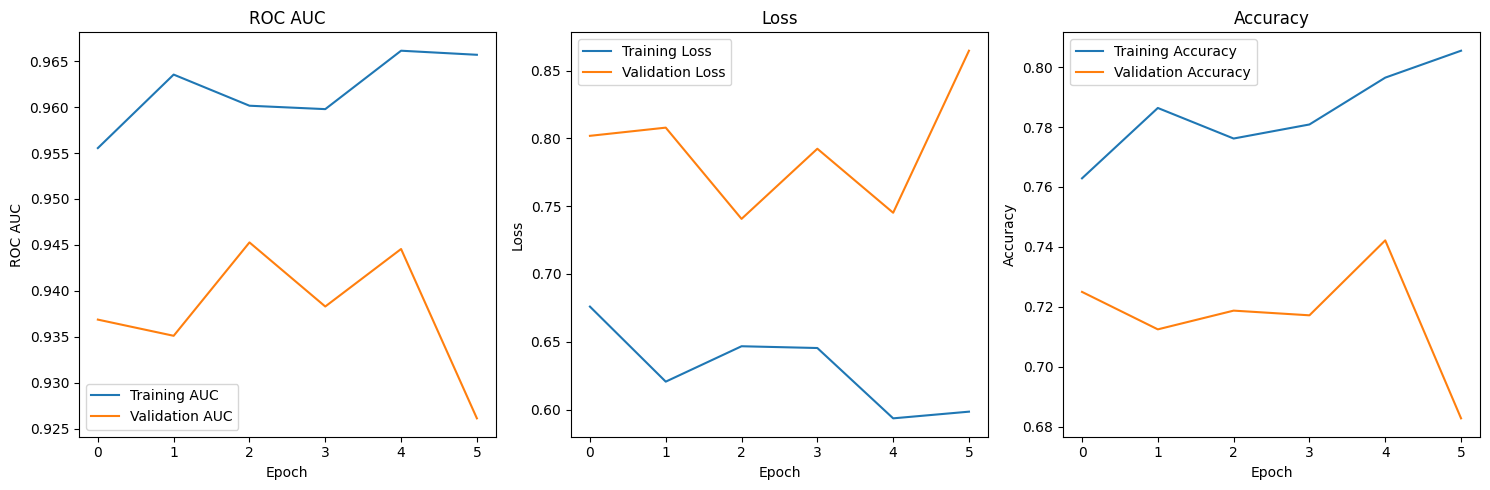

In [ ]:
# Extract training and validation metrics
history = trained_model1.history

# Create a grid for plotting
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot ROC AUC
axes[0].plot(history['auc_1'], label='Training AUC')
axes[0].plot(history['val_auc_1'], label='Validation AUC')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('ROC AUC')
axes[0].set_title('ROC AUC')
axes[0].legend()

# Plot loss
axes[1].plot(history['loss'], label='Training Loss')
axes[1].plot(history['val_loss'], label='Validation Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_title('Loss')
axes[1].legend()

# Plot accuracy
axes[2].plot(history['accuracy'], label='Training Accuracy')
axes[2].plot(history['val_accuracy'], label='Validation Accuracy')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Accuracy')
axes[2].set_title('Accuracy')
axes[2].legend()

# Adjust spacing and layout
plt.tight_layout()

# Display the plot
plt.show()

In [ ]:
optimizer = model1.optimizer
print(optimizer)
learning_rate = optimizer.learning_rate.numpy()
print("Current learning rate:", learning_rate)

Current learning rate: 0.001


From the graphs, we can infer the following about the model and its training:

* ROC AUC Graph: The Training AUC is increasing consistently, which is a good sign as it means the model is learning well from the training data. However, the Validation AUC decreases after the second epoch, which could indicate that the model is not generalizing well to unseen data and might be overfitting.
* Loss Graph: The Training Loss is decreasing consistently, which is expected as the model should improve and make fewer errors with each epoch. However, the Validation Loss increases after the first epoch, which again suggests overfitting. This means the model is fitting too closely to the training data and is not able to perform well on the validation data.
* Accuracy Graph: The Training Accuracy is increasing consistently, indicating the model is getting better at predicting the correct labels for the training data. However, the Validation Accuracy decreases after the second epoch, suggesting the model’s performance on unseen data is deteriorating.

Overall, these graphs suggest that the model might be overfitting to the training data. Overfitting happens when a model learns the detail and noise in the training data to the extent that it negatively impacts the performance of the model on new data. This means that the noise or random fluctuations in the training data is picked up and learned as concepts by the model. The problem is that these concepts do not apply to new data and negatively impact the model’s ability to generalize.

To address this, we might want to try techniques like regularization.

####2. 2nd Model
Let's try to optimize our base model further by using regularizaton technique to correct overfitting in our model. We will keep architecture and other values same but change following hyper-parameters:
* dropout value: 0.1, introduces stochasticity which can help prevent overfitting and improve generalization

In [ ]:
model2 = tf.keras.metrics.AUC()

model2 = Sequential()

# Convolution layers
model2.add(Conv2D(filters=8, kernel_size=(3,3), activation='relu', input_shape=(150, 150, 3)))
model2.add(MaxPooling2D(pool_size=(2,2)))
model2.add(Dropout(0.1))
model2.add(Conv2D(filters=8, kernel_size=(3,3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2,2)))
model2.add(Dropout(0.1))

# Dense layer
model2.add(Flatten())
model2.add(Dense(6, activation='softmax'))

model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', model1_ROC])

model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 148, 148, 8)       224       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 74, 74, 8)         0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 74, 74, 8)         0         
                                                                 
 conv2d_5 (Conv2D)           (None, 72, 72, 8)         584       
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 36, 36, 8)         0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 36, 36, 8)        

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss',
                                patience=3,
                                restore_best_weights=True)
trained_model2 = model2.fit(train_generator,
                            steps_per_epoch=20,
                            epochs=10,
                            validation_data=validation_generator,
                            validation_steps=5,
                            verbose=1,
                            callbacks=[early_stopping])

Epoch 1/10
20/20 [==============================] - 8s 188ms/step - loss: 1.6478 - accuracy: 0.2961 - auc_1: 0.7428 - val_loss: 1.3333 - val_accuracy: 0.5203 - val_auc_1: 0.8437
Epoch 2/10
20/20 [==============================] - 2s 118ms/step - loss: 1.2161 - accuracy: 0.5262 - auc_1: 0.8523 - val_loss: 1.0801 - val_accuracy: 0.5875 - val_auc_1: 0.8839
Epoch 3/10
20/20 [==============================] - 2s 122ms/step - loss: 1.1257 - accuracy: 0.5699 - auc_1: 0.8728 - val_loss: 1.0603 - val_accuracy: 0.6094 - val_auc_1: 0.8898
Epoch 4/10
20/20 [==============================] - 2s 121ms/step - loss: 1.0231 - accuracy: 0.6211 - auc_1: 0.8964 - val_loss: 1.0686 - val_accuracy: 0.5828 - val_auc_1: 0.8848
Epoch 5/10
20/20 [==============================] - 2s 102ms/step - loss: 1.0015 - accuracy: 0.6340 - auc_1: 0.9009 - val_loss: 0.9708 - val_accuracy: 0.6531 - val_auc_1: 0.9081
Epoch 6/10
20/20 [==============================] - 3s 152ms/step - loss: 0.9750 - accuracy: 0.6348 - auc_1: 0

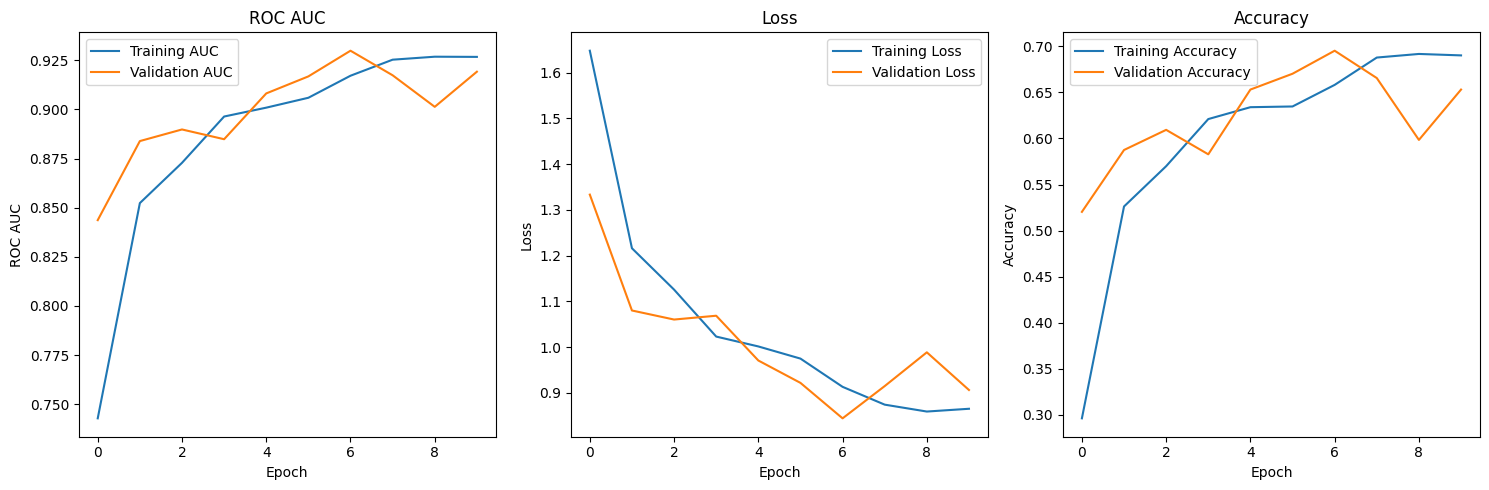

In [ ]:
# Extract training and validation metrics
history = trained_model2.history

# Create a grid for plotting
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot ROC AUC
axes[0].plot(history['auc_1'], label='Training AUC')
axes[0].plot(history['val_auc_1'], label='Validation AUC')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('ROC AUC')
axes[0].set_title('ROC AUC')
axes[0].legend()

# Plot loss
axes[1].plot(history['loss'], label='Training Loss')
axes[1].plot(history['val_loss'], label='Validation Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_title('Loss')
axes[1].legend()

# Plot accuracy
axes[2].plot(history['accuracy'], label='Training Accuracy')
axes[2].plot(history['val_accuracy'], label='Validation Accuracy')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Accuracy')
axes[2].set_title('Accuracy')
axes[2].legend()

# Adjust spacing and layout
plt.tight_layout()

# Display the plot
plt.show()

From the graphs, we can infer the following about the model and its training:

* ROC AUC Graph: Both Training AUC and Validation AUC increase over epochs, with Training AUC being consistently higher. This is a good sign as it means the model is learning well from the training data and is also generalizing well to unseen data.
* Loss Graph: Both Training Loss and Validation Loss decrease over epochs; however, Training Loss decreases at a faster rate. This is expected as the model should improve and make fewer errors with each epoch. The fact that Validation Loss is also decreasing suggests that the model is not overfitting and is able to perform well on the validation data.
* Accuracy Graph: Both Training Accuracy and Validation Accuracy increase over epochs with Training Accuracy being consistently higher. This indicates the model is getting better at predicting the correct labels for both the training data and unseen data.
Overall, these graphs suggest that the regularization technique we applied has helped to improve the model’s ability to generalize to unseen data. It seems to have mitigated the overfitting issue observed in the previous graphs. This is a good sign that your model is now more robust and should perform better on new, unseen data.

# Evaluate the model performance on test set

In [ ]:
test_labels = to_categorical(test_labels)
test_loss = model2.evaluate(test_images, test_labels)

94/94 [==============================] - 1s 8ms/step - loss: 114.0431 - accuracy: 0.6053 - auc_1: 0.7662


We see that we achieve 0.76 accuracy on the testing test with our second which is good.

# Conclusion
We can conclude that our second model performed the best with adam optimizer and 0.001 learning rate with dropout regularization technique.

Dropout regularization hyper-paramter tuning improved the performance for our base model by eliminatig overfitting.

# Github Link

https://github.com/arunattri26/MSDS/blob/main/DTSA_5511_Introduction_to_Deep_Learning/FinalProject.ipynb

# References:
* https://www.tensorflow.org/addons/tutorials/layers_normalizations
* https://www.kaggle.com/code/vincee/intel-image-classification-cnn-keras/notebook
* https://keras.io/examples/generative/cyclegan/